## Fill CRUJRA weather over Antartica with data from GSWP3

Will Wieder

Sept 2024

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [ ]:
# CRUJRA data
Cfin = '/glade/campaign/cgd/tss/projects/TRENDY2024/inputs/three_stream/'
Cftypes = ['Prec','Solr','TPQWL']
Cdir_in = 'clmforc.CRUJRAv2.5_0.5x0.5.'

# GSWP3 DATA
Gfin = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/atm_forcing.datm7.GSWP3.0.5d.v1.c200929/'
Gftypes = ['Precip','Solar','TPHWL']
Gdir_in = 'clmforc.GSWP3.c2011.0.5x0.5.'

vars = ['PRECTmms','FSDS',['TBOT','PSRF','QBOT','WIND','FLDS']]
debug = False

out_dir = '/glade/derecho/scratch/wwieder/TRENDY2024/inputs/three_stream/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)

v = 0
for Cftype in Cftypes:
    print('starting '+Cftype)
    Gftype = Gftypes[v]
    for year in range(1901, 1921):
        year = str(year)
        print(year)
        # list of files
        Cfiles = []
        Gfiles = []

        Cfiles.extend(sorted(glob(join(Cfin, '*' + Cftype + "." + year + "*.nc"))))
        Gfiles.extend(sorted(glob(join(Gfin, Gftype, '*' + Cftype + "." + year + "*.nc"))))

        Cds = xr.open_mfdataset(Cfiles, decode_times=True, combine='by_coords', parallel=True)
        Gds = xr.open_mfdataset(Gfiles, decode_times=True, combine='by_coords',parallel=True)

        # check that lat-lon dimensions are identical
        if debug == True:
            print(Cfiles)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).min().values)
            print((Gds.LONGXY.isel(time=0) - Cds.LONGXY).max().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).min().values)
            print((Gds.LATIXY.isel(time=0) - Cds.LATIXY).max().values)

        # assign missing coords to GSWP3 (this may not be necessary?)
        Gds = Gds.assign_coords({'lon': Cds.lon})
        Gds = Gds.assign_coords({'lat': Cds.lat})

        # Couldn't get interp_like to work as intended, using resample and coarsen instead?
        # just select the nearest values for solar, time mean for others
        if Cftype == 'Solr':
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].resample(time="6h").nearest()
        else:
            with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                x = Gds[vars[v]].coarsen(time=2, boundary="trim").mean()
        
        #with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        #    x = Gds.PRECTmms.interp_like(Cds.PRECTmms,method='linear',assume_sorted=False)

        # Create the output dataset where GSWP3 is used south of 60S
        ds_out = Cds.copy('deep')
        ds_out[vars[v]] = xr.where(ds_out.lat < -60, x, ds_out[vars[v]])
        if debug == True:
            ds_out[vars[v]].mean('time').plot(robust=True) ;

        # Write out the new file
        fout = out_dir + Cdir_in + Cftype+"."+year+".nc"
        ds_out.to_netcdf(fout, format="NETCDF4")
        #print('wrote '+fout)

    v = v+1

starting Prec
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911


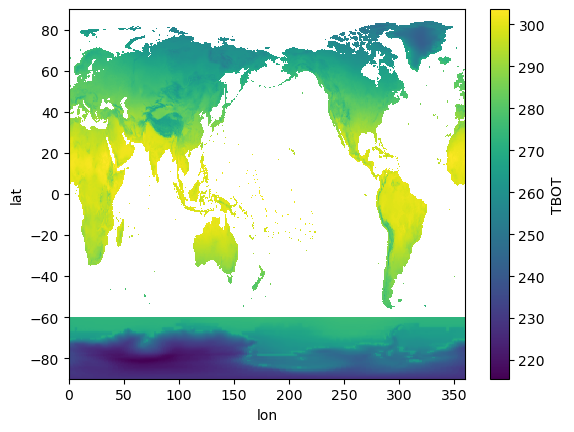

In [91]:
ds_out.WIND.mean('time').plot() ;

In [84]:
.time

<xarray.DataArray 'time' (time: 1460)> Size: 12kB
array([cftime.DatetimeNoLeap(1901, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 1, 1, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 1, 1, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1901, 12, 31, 6, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 12, 31, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 12, 31, 18, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 12kB 1901-01-01 00:00:00 ... 1901-12-31 18:00:00
Attributes:
    long_name:  observation time

<xarray.DataArray 'time' (time: 1460)> Size: 12kB
array([cftime.DatetimeNoLeap(1901, 1, 1, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 1, 1, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 1, 1, 15, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1901, 12, 31, 9, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 12, 31, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1901, 12, 31, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 12kB 1901-01-01 03:00:00 ... 1901-12-31 21:00:00
Attributes:
    long_name:  observation time

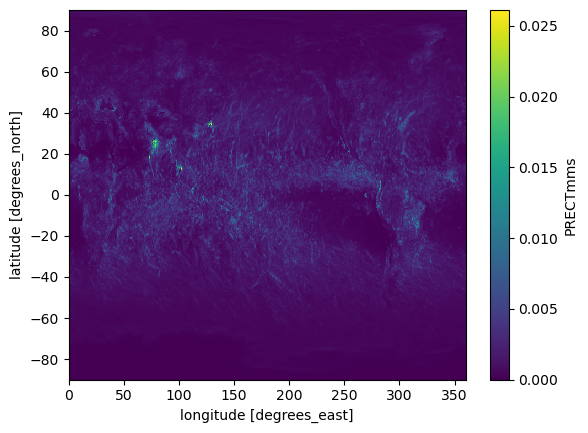

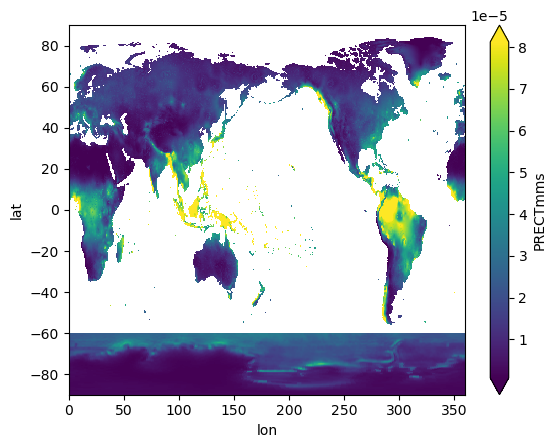

In [69]:
x.sum().values

array(10676.061, dtype=float32)

In [70]:
Gds.PRECTmms.sum().values

array(21352.133, dtype=float32)

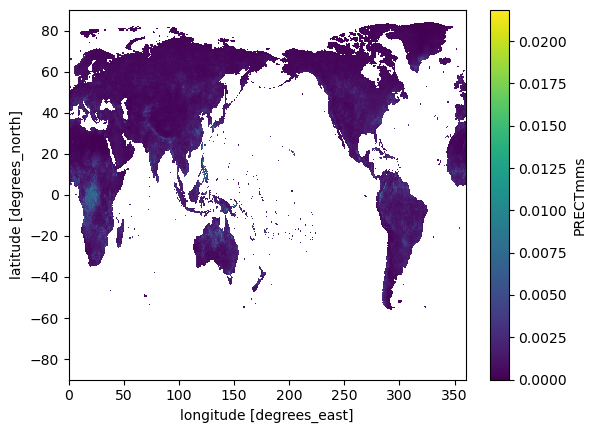

In [33]:
Cds.PRECTmms.max('time').plot()

In [ ]:
        
        # Open datasets

        # Assign coords
        LATI=ds.LATIXY.isel(time=0,lon=0).values
        LONG=ds.LONGXY.isel(time=0,lat=0).values
        ds = ds.assign_coords({'lon': LONG, 'lat':LATI})

        # Subset data & modify fillValues
        ds = ds.sel(lat=plat,lon=plon, method='nearest')
        ds= ds.expand_dims(dim={"lat": 1},axis=1)
        ds= ds.expand_dims(dim={"lon": 1},axis=2)
        ds['LONGXY'] = ds['LONGXY'].isel(time=0)
        ds['LATIXY'] = ds['LATIXY'].isel(time=0)
        ds['time'].attrs['_FillValue'] = 1.e36
        ds['LONGXY'].attrs['_FillValue'] = 1.e36
        ds['LATIXY'].attrs['_FillValue'] = 1.e36
        ds['lat'].attrs['_FillValue'] = 1.e36
        ds['lon'].attrs['_FillValue'] = 1.e36
        print('...loading data...')
        ds = ds.persist() 
        _ = wait(ds)

        if year == '202':
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-2022_nc4.nc'
        else: 
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-'+str(int(year)*10+9)+'_nc4.nc'
        ds.to_netcdf(fout)
        print('wrote '+fout)

print("-- done! --")

## Look at datm 

In [40]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic.2010-2019.nc',
                     decode_times=True)
ds3 = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic3.2010-2019.nc',
                       decode_times=True)
niwot = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/CLM1PT_data/PLUMBER2/US-NR1/CLM1PT_data/CTSM_DATM_US-NR1_1999-2014.nc'
niwot = xr.open_mfdataset(niwot, decode_times=True).isel(lat=0,lon=0)
niwot.time

<xarray.DataArray 'time' (time: 280512)>
array(['1999-01-01T07:00:00.000000000', '1999-01-01T07:30:00.000000000',
       '1999-01-01T08:00:00.000000000', ..., '2015-01-01T05:29:52.000000000',
       '2015-01-01T06:00:16.000000000', '2015-01-01T06:30:08.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T07:00:00 ... 2015-01-01T06:30:08
Attributes:
    long_name:  observation time

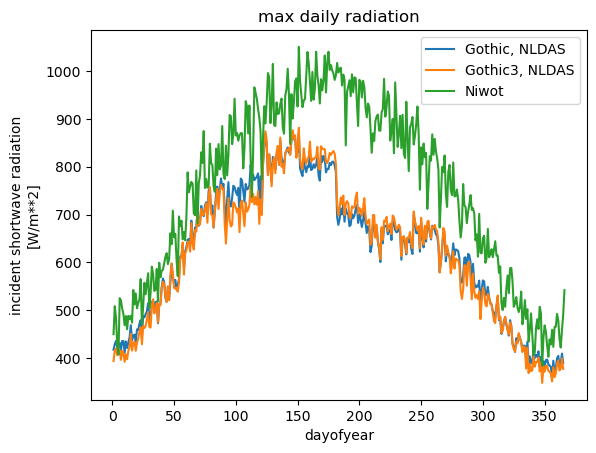

In [42]:
ds.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.title('max daily radiation')
plt.legend() ;

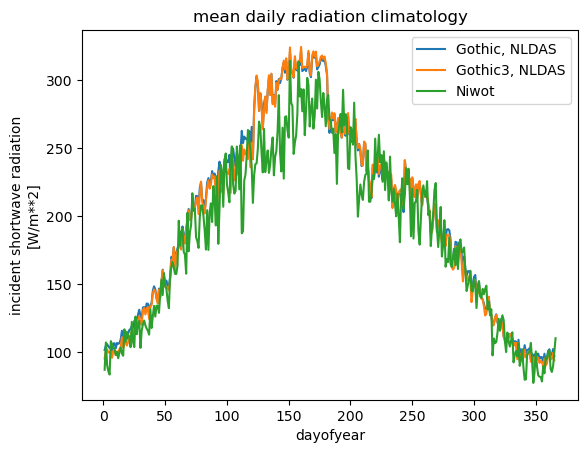

In [44]:
ds.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.title('mean daily radiation climatology')
plt.legend() ;

In [45]:
niwot.FSDS.sel(time=niwot.time.dt.month.isin([5])).time[0:24]

<xarray.DataArray 'time' (time: 24)>
array(['1999-05-01T00:00:00.000000000', '1999-05-01T00:30:00.000000000',
       '1999-05-01T01:00:00.000000000', '1999-05-01T01:30:00.000000000',
       '1999-05-01T02:00:00.000000000', '1999-05-01T02:30:00.000000000',
       '1999-05-01T03:00:00.000000000', '1999-05-01T03:30:00.000000000',
       '1999-05-01T04:00:00.000000000', '1999-05-01T04:30:00.000000000',
       '1999-05-01T05:00:00.000000000', '1999-05-01T05:30:00.000000000',
       '1999-05-01T06:00:00.000000000', '1999-05-01T06:30:00.000000000',
       '1999-05-01T07:00:00.000000000', '1999-05-01T07:30:00.000000000',
       '1999-05-01T08:00:00.000000000', '1999-05-01T08:30:00.000000000',
       '1999-05-01T09:00:00.000000000', '1999-05-01T09:30:00.000000000',
       '1999-05-01T10:00:00.000000000', '1999-05-01T10:30:00.000000000',
       '1999-05-01T11:00:00.000000000', '1999-05-01T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-05-01 ... 1999-05-01T11:30:00
Attributes:
    long_name:  observation time

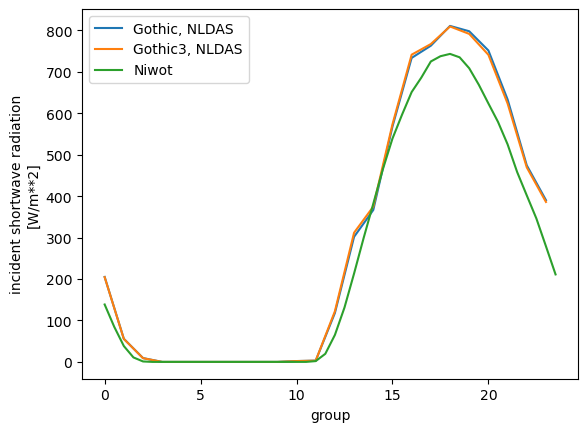

In [66]:
nmonth = 5
ndays = 31
nyears = 16

ds.FSDS.sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.sel(time=ds3.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic3, NLDAS')

nwtPlot = niwot.FSDS.sel(time=niwot.time.dt.month.isin([nmonth]))
x = list((range(48)))*ndays*nyears #31 days for 16 years
x = np.array(x,dtype=float)
x = x/2
grouper = xr.DataArray(
    pd.Index(x),
    dims=['time'], coords=[nwtPlot.time],
)

nwtPlot.groupby(grouper).mean(dim='time').plot(label='Niwot')
plt.legend() ;

# May have to manually write these to nc5
nccopy -k cdf5 /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2020-2022.nc /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo2.c2020.Solar.gothic.2020-2022.nc

In [67]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic.2010-2019.nc',
                     decode_times=True)
ds3 = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic3.2010-2019.nc',
                       decode_times=True)

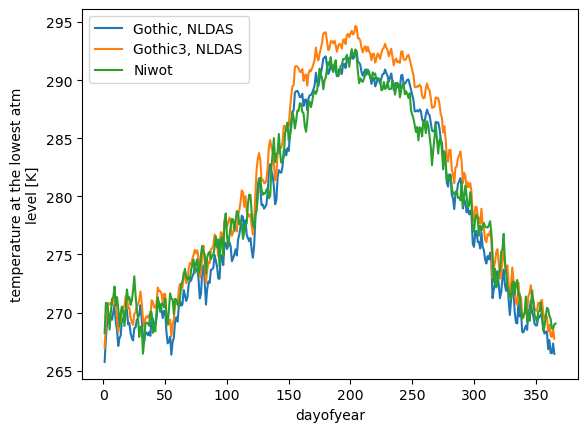

In [68]:
var = 'TBOT'
ds[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.legend();


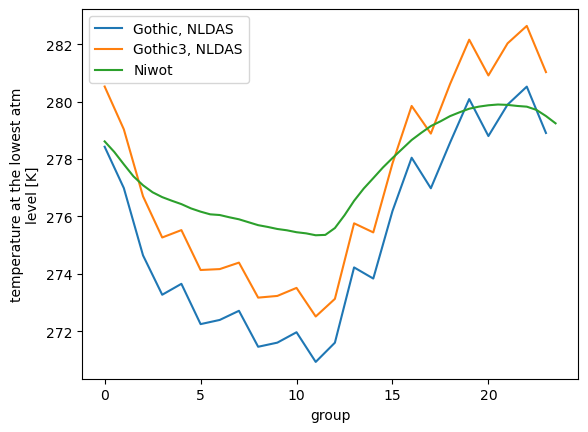

In [69]:
nmonth = 5
ndays = 31
nyears = 16

ds[var].sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
ds3[var].sel(time=ds3.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic3, NLDAS')

nwtPlot = niwot[var].sel(time=niwot.time.dt.month.isin([nmonth]))
x = list((range(48)))*ndays*nyears #31 days for 16 years
x = np.array(x,dtype=float)
x = x/2
grouper = xr.DataArray(
    pd.Index(x),
    dims=['time'], coords=[nwtPlot.time],
)

nwtPlot.groupby(grouper).mean(dim='time').plot(label='Niwot')
plt.legend() ;

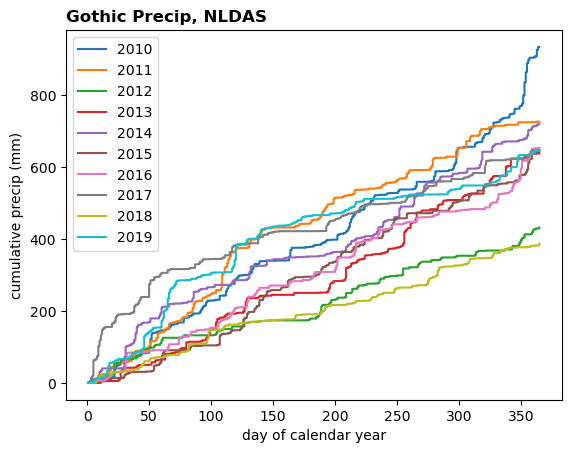

In [22]:
sph = 3600
cumPPT = ((ds.PRECTmms.groupby('time.year').cumsum())*sph)
cumPPT = cumPPT.isel(lat=0, lon=0)
for year in range(2010, 2020):
    plot = xr.where(cumPPT['time.year'] == year, cumPPT, np.nan)
    x = plot['time.dayofyear']
    y = plot
    plt.plot(x, y, label=str(year))

plt.legend()
plt.ylabel('cumulative precip (mm)')
plt.xlabel('day of calendar year')
plt.title('Gothic Precip, NLDAS', loc='left', fontsize='large', fontweight='bold') ;